# psychothreshold - Time varying

In [1]:
import numpy as np
import random

# RTDs in real and scaled time units should match
ILD_arr  = [0.5]
ABL_arr = [40]

t_non_decision = 0
rate_lambda = 0.1
T_0 = 0.9 * 1e-3
theta_E = 100
dt = 1e-4
c = 0.1
c1 = 0.01


# def tied_abs_units(ILD, ABL, rate_lambda, theta_E, T_0, t_non_decision, dt):
#     DV = 0; t = 0
#     chi = 17.37
#     dB = np.sqrt(dt)

#     while True:
#         mu = (2/T_0) * (10**(rate_lambda*ABL/20)) * (rate_lambda * ILD / chi) * (1/c)*np.exp(-t/c)
#         sigma = np.sqrt((2/T_0)* (10**(rate_lambda*ABL/20)) * (1/c)*np.exp(-t/c))

#         DV += mu*dt + sigma * np.random.normal(0, dB)
#         t += dt

#         # bounds are +1 and -1 as simulation is done in normalized units
#         if DV >= theta_E or DV <= -theta_E:
#             return t

max_time = 10.0  # ms

def tied_abs_units(ILD, ABL, rate_lambda, theta_E, T_0, t_non_decision, dt):
    max_steps = int(np.ceil(max_time / dt))
    t = np.arange(0, max_steps * dt, dt)
    dB = np.sqrt(dt)
    chi = 17.37

    common = (2 / T_0) * (10 ** (rate_lambda * ABL / 20))
    
    decay = np.exp(-t / c)
    mu = common * (rate_lambda * ILD / chi) * ((1 / c) * decay + c1)
    sigma = np.sqrt(common * ((1 / c) * decay + c1))
    
    noise = np.random.normal(0, dB, size=max_steps)
    
    increments = mu * dt + sigma * noise
    DV = np.cumsum(increments)
    
    crossing_indices = np.where((DV >= theta_E) | (DV <= -theta_E))[0]
    if crossing_indices.size > 0:
        t_cross = t[crossing_indices[0]]
        return t_cross + t_non_decision  
    else:
        return np.nan




# def tied_rescaled_units(ILD, ABL, rate_lambda, theta_E, T_0, t_non_decision, dt):
#     DV = 0; t = 0
#     chi = 17.37
#     dB = np.sqrt(dt)

#     while True:
#         mu = (rate_lambda * theta_E * ILD / chi) 
#         sigma = 1

#         DV += mu*dt + sigma * np.random.normal(0, dB)
#         t += dt
        
#         if DV >= 1 or DV <= -1:
#             return t

def tied_rescaled_units(ILD, ABL, rate_lambda, theta_E, T_0, t_non_decision, dt):
    chi = 17.37
    dB = np.sqrt(dt)
    
    mu = (rate_lambda * theta_E * ILD / chi)
    sigma = 1
    
    max_steps = int(np.ceil(max_time / dt))
    t_arr = np.arange(0, max_steps * dt, dt)

    
    noise = np.random.normal(0, dB, max_steps)
    
    increments = mu * dt + sigma * noise
    DV = np.cumsum(increments)
    
    crossing_indices = np.where((DV >= 1) | (DV <= -1))[0]
    if crossing_indices.size > 0:
        return t_arr[crossing_indices[0]]
    else:
        return np.nan
    

In [2]:
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

In [3]:
N_sim = int(10e3)
rt_abs = Parallel(n_jobs=30)(delayed(tied_abs_units)(ILD_arr[0], ABL_arr[0], rate_lambda, theta_E, T_0, t_non_decision, dt) for _ in range(N_sim))
print('abs done')
rt_rescaled = Parallel(n_jobs=30)(delayed(tied_rescaled_units)(ILD_arr[0], ABL_arr[0], rate_lambda, theta_E, T_0, t_non_decision, dt) for _ in range(N_sim))

abs done


In [4]:
print(f'max of rt abs = {np.nanmax(rt_abs)}')

max of rt abs = 9.9818


In [5]:
import numpy as np
from scipy.optimize import brentq

def compute_t_scalar(tau, omega, c, c1):
    """
    Numerically solve for t in the equation:
        tau = omega*(1 - exp(-t/c)) + c1*t
    for a single scalar value of tau using a bracketing method (Brent's method).
    
    Parameters:
        tau   : float
            The value of tau.
        omega : float
            The parameter omega.
        c     : float
            The parameter c.
        c1    : float
            The parameter c1.
    
    Returns:
        t_sol : float
            The numerical solution for t.
    """
    # Define the function f(t) = omega*(1 - exp(-t/c)) + c1*t - tau
    def f(t):
        return omega * (1 - np.exp(-t / c)) + c1 * t - tau

    # We know that f(0) = -tau. If tau > 0, f(0) is negative.
    # Since the derivative f'(t)= (omega/c)*exp(-t/c) + c1 is positive,
    # f is monotonic increasing and f(t) will eventually become positive.
    # We now find a bracket [t_low, t_high] such that f(t_low) < 0 and f(t_high) > 0.
    
    t_low = 0.0
    # A first guess for t_high: if c1 is nonzero, start with tau/c1,
    # otherwise use tau (or a small positive value) to ensure a positive guess.
    t_high = tau / c1 if c1 != 0 else tau
    if t_high <= t_low:
        t_high = t_low + 1.0

    # If f(t_high) is not positive, increase t_high until it is.
    while f(t_high) <= 0:
        t_high *= 2

    # Now use Brent's method to find the root in [t_low, t_high].
    t_sol = brentq(f, t_low, t_high)
    return t_sol

def compute_t_from_tau(tau, omega, c, c1):
    """
    Numerically solve for t in the equation:
        tau = omega*(1 - exp(-t/c)) + c1*t
    for tau. The input tau can be a scalar or a NumPy array.
    
    Returns:
        t_sol : scalar or NumPy array of solutions.
    """
    # Ensure tau is treated as an array.
    tau_array = np.atleast_1d(tau)
    
    # Compute solution for each element.
    t_solutions = np.array([compute_t_scalar(t_i, omega, c, c1) for t_i in tau_array])
    
    # If the original tau was a scalar, return a scalar.
    return t_solutions[0] if t_solutions.size == 1 else t_solutions



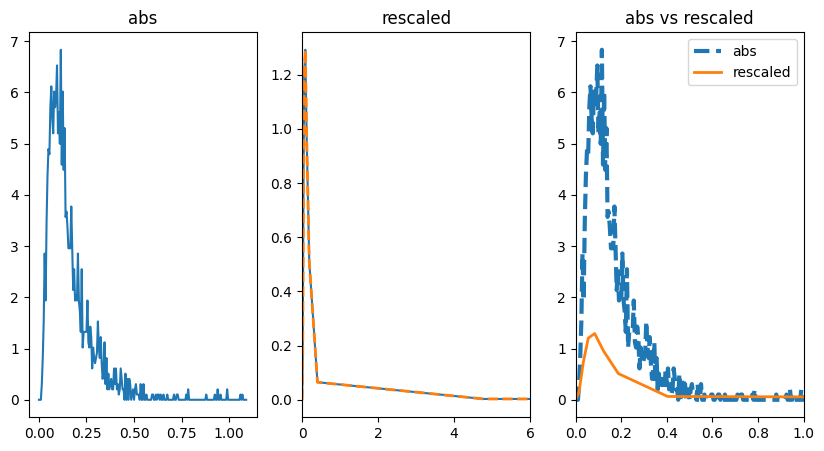

In [16]:
bins = np.arange(0, 1 + 0.1, 5e-3)

# abs
abs_hist, _ = np.histogram(rt_abs, bins=bins, density=True)
plt.figure(figsize=(10, 5))
plt.subplot(1,3,1)
plt.plot(bins[:-1], abs_hist)
plt.title('abs')
# rescaled
bins_in_tau = np.arange(0, 6, 0.05)
rescaled_hist, _ = np.histogram(rt_rescaled, bins=bins_in_tau, density=True)

# A = (2 / (T_0 * (theta_E ** 2))) * (10 ** (rate_lambda * ABL_arr[0] / 20))
# bins_in_t_from_tau = -c * np.log(1 - bins_in_tau / A)
omega = (2 / (T_0 * (theta_E ** 2))) * (10 ** (rate_lambda * ABL_arr[0] / 20))
bins_in_t_from_tau = compute_t(bins_in_tau, omega, c, c1)

dtau_by_dt = (2 / (T_0 * (theta_E**2))) * (10**(rate_lambda*ABL_arr[0]/20)) * ((1/c)*(np.exp(-bins_in_t_from_tau[:-1]/c)) + c1)
rescaled_hist_times_dtau_dt = rescaled_hist * dtau_by_dt

plt.subplot(1,3,2)
plt.plot(bins_in_t_from_tau[:-1], rescaled_hist_times_dtau_dt)
plt.plot(bins_in_t_from_tau[:-1], rescaled_hist_times_dtau_dt, label='rescaled', lw=2, ls='--')

plt.title('rescaled')
plt.xlim(0, 6)

plt.subplot(1,3,3)
# plot both
plt.plot(bins[:-1], abs_hist, label='abs', ls='--', lw=3)
plt.plot(bins_in_t_from_tau[:-1], rescaled_hist_times_dtau_dt, label='rescaled', lw=2)
plt.legend()
plt.title('abs vs rescaled')
plt.xlim(0, 1);

In [ ]:
print(f'A is {A}')
print(f'max of tau = {np.nanmax(bins_in_tau)} ')

# for diff ABL ?

In [ ]:
ABL_arr = [60]
abl_60_rel_rt = Parallel(n_jobs=30)(delayed(tied_rescaled_units)(ILD_arr[0], ABL_arr[0], rate_lambda, theta_E, T_0, t_non_decision, dt) for _ in range(N_sim))

print('60 done')
ABL_arr = [20]
abl_20_rel_rt = Parallel(n_jobs=30)(delayed(tied_rescaled_units)(ILD_arr[0], ABL_arr[0], rate_lambda, theta_E, T_0, t_non_decision, dt) for _ in range(N_sim))

ABL_arr = [40]
abl_40_rel_rt = Parallel(n_jobs=30)(delayed(tied_rescaled_units)(ILD_arr[0], ABL_arr[0], rate_lambda, theta_E, T_0, t_non_decision, dt) for _ in range(N_sim))


In [ ]:
np.max(abl_60_rel_rt), np.max(abl_20_rel_rt)
bins = np.arange(0, 10, 0.05)
plt.hist(abl_60_rel_rt, bins=bins, density=True, alpha=0.5, label='ABL 60', histtype='step')
plt.hist(abl_20_rel_rt, bins=bins, density=True, alpha=0.5, label='ABL 20', histtype='step')
plt.hist(abl_40_rel_rt, bins=bins, density=True, alpha=0.5, label='ABL 40', histtype='step')
plt.legend()
plt.title('ABL 60 vs 20')

In [9]:
def rho_tau_vs_t(rt_rescaled,ABL):
    bins_in_tau = np.arange(0, max(rt_rescaled) + 0.1, 0.1)
    rescaled_hist, _ = np.histogram(rt_rescaled, bins=bins_in_tau, density=True) # rho(tau)

    A = (2 / (T_0 * (theta_E ** 2))) * (10 ** (rate_lambda * ABL / 20))
    bins_in_t_from_tau = -c * np.log(1 - bins_in_tau / A) # t

    dtau_by_dt = (2 / (T_0 * (theta_E**2))) * (10**(rate_lambda*ABL/20)) * (1/c)*(np.exp(-bins_in_t_from_tau[:-1]/c))
    rescaled_hist_times_dtau_dt = rescaled_hist * dtau_by_dt
    return bins_in_t_from_tau[:-1], rescaled_hist_times_dtau_dt

In [ ]:
t_60, rt_60_t_units = rho_tau_vs_t(abl_60_rel_rt, 60)
t_20, rt_20_t_units = rho_tau_vs_t(abl_20_rel_rt, 20)
t_40, rt_40_t_units = rho_tau_vs_t(abl_40_rel_rt, 40)

In [11]:
rt_abs_60 = Parallel(n_jobs=30)(delayed(tied_abs_units)(ILD_arr[0], 60, rate_lambda, theta_E, T_0, t_non_decision, dt) for _ in range(N_sim))
rt_abs_40 = Parallel(n_jobs=30)(delayed(tied_abs_units)(ILD_arr[0], 40, rate_lambda, theta_E, T_0, t_non_decision, dt) for _ in range(N_sim))
rt_abs_20 = Parallel(n_jobs=30)(delayed(tied_abs_units)(ILD_arr[0], 20, rate_lambda, theta_E, T_0, t_non_decision, dt) for _ in range(N_sim))

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.plot(t_60, rt_60_t_units, label='ABL 60')
plt.plot(t_20, rt_20_t_units, label='ABL 20')
plt.plot(t_40, rt_40_t_units, label='ABL 40')
plt.legend()
plt.title('RTDs for ABL tau -> t')

plt.subplot(1,2,2)
t_bins = np.arange(0, 2, 0.05)
plt.hist(rt_abs_60, bins=t_bins, density=True,  label='ABL 60', histtype='step')
plt.hist(rt_abs_20, bins=t_bins, density=True,  label='ABL 20', histtype='step')
plt.hist(rt_abs_40, bins=t_bins, density=True,  label='ABL 40', histtype='step')
plt.legend()
plt.title('RTDs for ABL, abs t')

# Q-Q plot

In [13]:
quantiles = np.arange(0.05, 0.95, 0.05)
# remove nans before taking quantiles
rt_abs_60 = np.array([rt for rt in rt_abs_60 if not np.isnan(rt)])
rt_abs_40 = np.array([rt for rt in rt_abs_40 if not np.isnan(rt)])
rt_abs_20 = np.array([rt for rt in rt_abs_20 if not np.isnan(rt)])

quantiles_abs_60 = np.quantile(rt_abs_60, quantiles)
quantiles_abs_40 = np.quantile(rt_abs_40, quantiles)
quantiles_abs_20 = np.quantile(rt_abs_20, quantiles)

In [ ]:
plt.plot(quantiles_abs_60, quantiles_abs_40, label='60 vs 40')
plt.plot(quantiles_abs_60, quantiles_abs_20, label='60 vs 20')
plt.plot(quantiles_abs_60, quantiles_abs_60, label='60 vs 60', ls='--', alpha=0.4)

plt.legend()
plt.title('Q-Q abs units')

In [1]:
V_A_bounds = [0.2, 1.2]
theta_A_bounds = [0.5, 1.5]

rate_lambda_bounds = [0.01, 0.15]
T_0_bounds = [0.1*(1e-3), 0.8*(1e-3)]
theta_E_bounds = [35, 65]

t_A_aff_bounds = [0.009, 0.07]
t_E_aff_bounds = [0.009, 0.07]
t_motor_bounds = [0.009, 0.07]

Z_E_bounds = [-10, 10]
L_bounds = [0.01, 2]
# ---
V_A_plausible_bounds = [0.3, 1]
theta_A_plausible_bounds = [0.7, 1.3]

rate_lambda_plausible_bounds =  [0.05, 0.09]
T_0_plausible_bounds = [0.15*(1e-3), 0.3*(1e-3)]
theta_E_plausible_bounds = [40, 55]

t_A_aff_plausible_bounds = [0.01, 0.05]
t_E_aff_plausible_bounds = [0.01, 0.05]
t_motor_plausible_bounds = [0.01, 0.05]

Z_E_plausible_bounds = [-6, 6]
L_plausible_bounds = [1.5, 1.999]

In [3]:
import numpy as np
np.random.seed(42)
V_A_0 = np.random.uniform(V_A_plausible_bounds[0], V_A_plausible_bounds[1])
theta_A_0 = np.random.uniform(theta_A_plausible_bounds[0], theta_A_plausible_bounds[1])
rate_lambda_0 = np.random.uniform(rate_lambda_plausible_bounds[0], rate_lambda_plausible_bounds[1])
T_0_0 = np.random.uniform(T_0_plausible_bounds[0], T_0_plausible_bounds[1])
theta_E_0 = np.random.uniform(theta_E_plausible_bounds[0], theta_E_plausible_bounds[1])
t_A_aff_0 = np.random.uniform(t_A_aff_plausible_bounds[0], t_A_aff_plausible_bounds[1])
t_E_aff_0 = np.random.uniform(t_E_aff_plausible_bounds[0], t_E_aff_plausible_bounds[1])
t_motor_0 = np.random.uniform(t_motor_plausible_bounds[0], t_motor_plausible_bounds[1])
Z_E_0 = np.random.uniform(Z_E_plausible_bounds[0], Z_E_plausible_bounds[1])
L_0 = np.random.uniform(L_plausible_bounds[0], L_plausible_bounds[1])


In [4]:
t_A_aff_0, t_E_aff_0, t_motor_0

(0.016239780813448106, 0.012323344486727979, 0.04464704583099741)